In [127]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import data_reader
import random
import warnings

warnings.filterwarnings('ignore')

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

#set font sizes for figures throughout
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

index = ['subj_id', 'session_no', 'block_no', 'trial_no']

In [112]:
dr = data_reader.DataReader()

# if Exp1 and Exp2 data need to be plotted alongside each other, read those data into separate dataframes
exp_1, exp_2 = 'HEM_exp_1', 'HEM_exp_2'
choices_1, dynamics_1, stim_viewing_1 = dr.get_data(path='../../data/%s/processed/' % (exp_1), stim_viewing=True)
choices_2, dynamics_2, stim_viewing_2 = dr.get_data(path='../../data/%s/processed/' % (exp_2), stim_viewing=True)

In [181]:
choices, dynamics, stim_viewing = choices_1, dynamics_1, stim_viewing_1
# choices, dynamics, stim_viewing = choices_2, dynamics_2, stim_viewing_2

In [ ]:
choices['early_it'] = stim_viewing.groupby(level=index).apply(
        lambda traj: traj.timestamp.max()-traj.timestamp[traj.mouse_dx==0].iloc[-1])

choices['stim_response'] = choices['early_it'] != 0
choices['early_response'] = choices['initiation_time'] == 0
choices.groupby(['stim_response', 'early_response']).size().unstack()/len(choices)

IT_0 is the basic algorithm used so far: look for the first change in mouse coordinate. For IT_1, we need to loop over each sample within each trajectory to extract individual submovements. IT_2 is eye initiation time.

In [114]:
def get_IT_0(traj):
    trimmed_traj = traj.drop_duplicates(subset=['mouse_x', 'mouse_y'], keep='last')
    return trimmed_traj.timestamp.min() - traj.timestamp.min()

def get_IT_1(traj):
    distance_threshold = 50
    v = traj.mouse_v.values

    onsets = []
    offsets = []
    is_previous_v_zero = True

    for i in np.arange(0,len(v)):
        if v[i]!=0:
            if is_previous_v_zero:
                is_previous_v_zero = False
                onsets += [i]
            elif (i==len(v)-1):
                offsets += [i]            
        elif (not is_previous_v_zero):
            offsets += [i]
            is_previous_v_zero = True

    submovements = pd.DataFrame([{'on': onsets[i], 
                     'off': offsets[i], 
                     'on_t': traj.timestamp.values[onsets[i]],
                     'distance':(traj.mouse_v[onsets[i]:offsets[i]]*traj.timestamp.diff()[onsets[i]:offsets[i]]).sum()}
                    for i in range(len(onsets))])

    return submovements.loc[submovements.distance.ge(distance_threshold).idxmax()].on_t

def get_IT_2(trajectory):
    eye_v_threshold = 500
    eye_v = trajectory.eye_v
    if ((eye_v < eye_v_threshold) | (trajectory.eye_v.isnull())).all():
        # if eye stays at one location throughout the whole trial, 
        # it is supposedly fixated either at the center of the screen, or at the response location
        # in the former case, initation time is inf, in the latter case, initation time is 0
        # we detect which case is tru  by looking at first value of eye_x
        if abs(trajectory.eye_x.iloc[0] < 100): 
            eye_IT = np.inf
            eye_initial_decision = 0
        else:
            eye_IT = 0
            eye_initial_decision = np.sign(trajectory.eye_x.iloc[0])
    else:
#         print(trajectory.index.unique().levels)
        eye_IT_idx = (eye_v > eye_v_threshold).nonzero()[0][0]
        eye_IT = trajectory.timestamp.iloc[eye_IT_idx]
        eye_initial_decision = np.sign(trajectory.eye_x.iloc[eye_IT_idx+1])

    return eye_IT

def get_ITs(trajectory):
    IT_0 = get_IT_0(trajectory)
    IT_1 = get_IT_1(trajectory)
    IT_2 = get_IT_2(trajectory)
    return pd.Series({'IT_0': IT_0, 
                      'IT_1': IT_1,
                      'IT_2': IT_2})

choices = choices.join(dynamics.groupby(level=index).apply(get_ITs))

0.27729166666666666


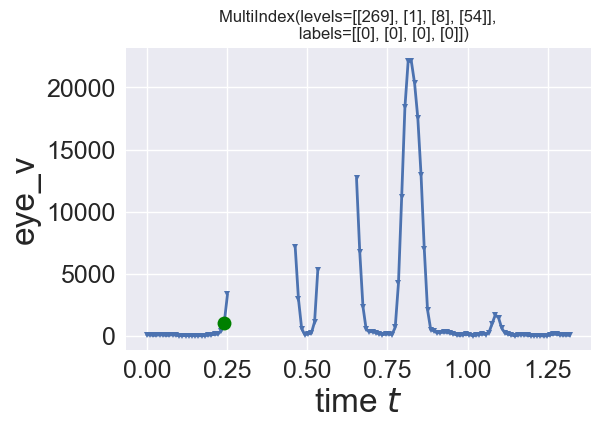

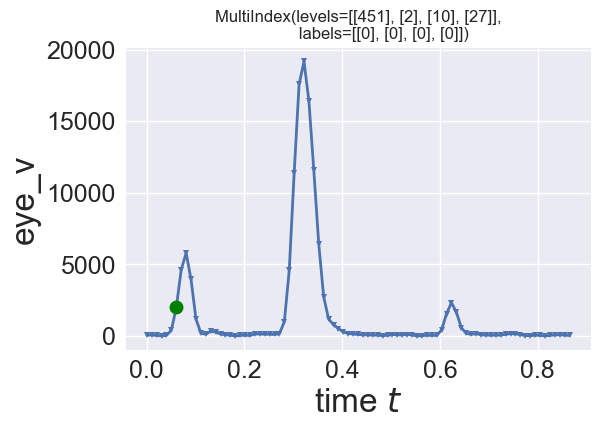

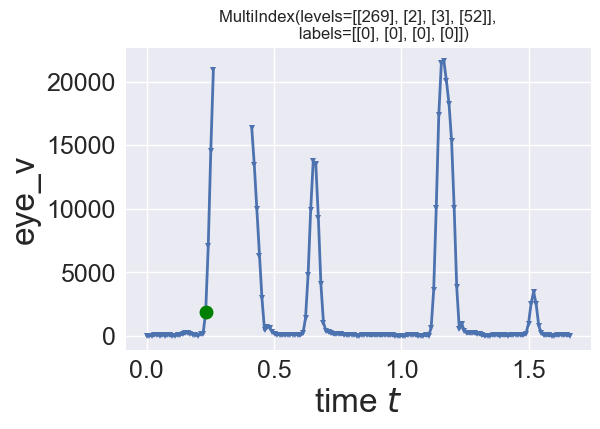

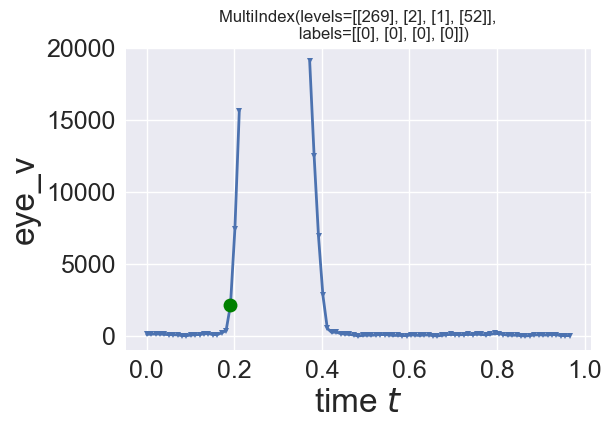

In [116]:
import random
import trajectory_plotter

tp = trajectory_plotter.TrajectoryPlotter()

choices_tmp = choices[abs(choices.mouse_IT-choices.eye_IT)>0.2]
print(len(choices_tmp)/len(choices))

for i in range(1,5):
    trial = random.sample(list(choices_tmp.index), 1)
    traj = dynamics.loc[trial]
    choice = choices.loc[trial]
    stim = stim_viewing.loc[trial]    

    it_0 = choice['IT_0'].values[0]
    v_it_0 = traj[traj.timestamp==it_0].mouse_v
    
    it_1 = choice['IT_1'].values[0]
    v_it_1 = traj[traj.timestamp==it_1].mouse_v
    
    it_2 = choice['IT_2'].values[0]
    v_it_2 = traj[traj.timestamp==it_2].eye_v

#     ax = tp.plot_trajectory_var(traj, var='mouse_v')
#     ax.plot(it_1, v_it_1, marker='o', ms=10, color='blue')
    
    ax = tp.plot_trajectory_var(traj, var='eye_v')
    ax.plot(it_2, v_it_2, marker='o', ms=10, color='green')
    
#     plt.figure()
#     plt.plot(traj.timestamp, traj.eye_x)


Now, let's look at eye initiation times.

In [182]:
to_discard = (choices.eye_IT == np.inf)
print('%i trials discarded due to no eye movements' % (to_discard.sum()))
# to_discard = (choices.eye_IT < 0.01) | (choices.eye_IT == np.inf) | (choices.mouse_IT < 0.01)

choices, dynamics = choices[~to_discard], dynamics[~to_discard]
choices.loc[:,'ID_lag'] = choices.mouse_IT - choices.eye_IT

7 trials discarded due to no eye movements


subj_id
269    0.127
275    0.095
391    0.414
451   -0.005
Name: ID_lag, dtype: float64

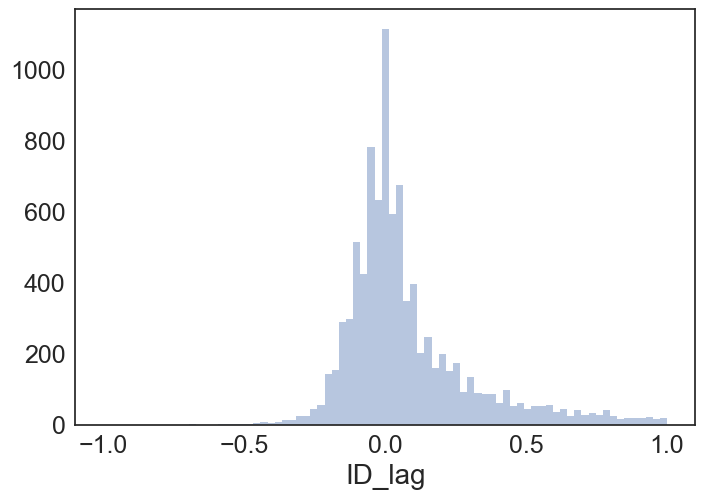

In [183]:
sns.distplot(choices.ID_lag, bins = np.linspace(-1, 1, 80), hist=True, kde=False)
choices.groupby('subj_id').ID_lag.mean()

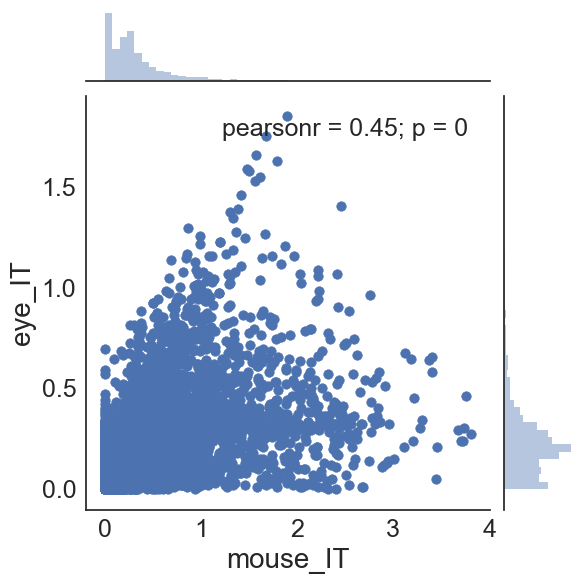

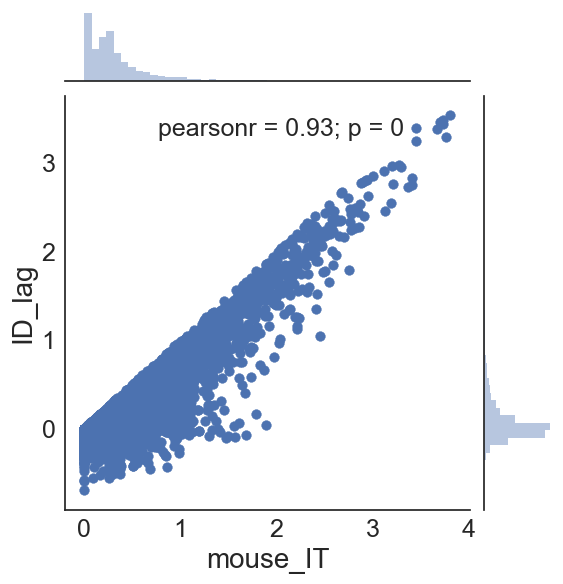

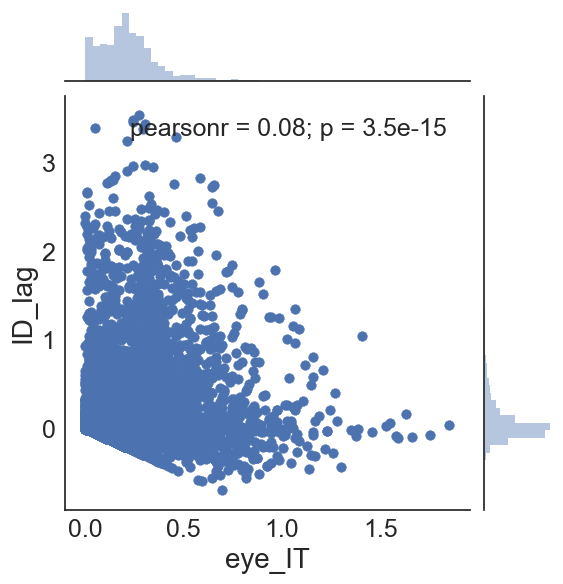

In [184]:
sns.jointplot(data=choices, x='mouse_IT', y='eye_IT')

sns.jointplot(data=choices, x='mouse_IT', y='ID_lag')
sns.jointplot(data=choices, x='eye_IT', y='ID_lag')

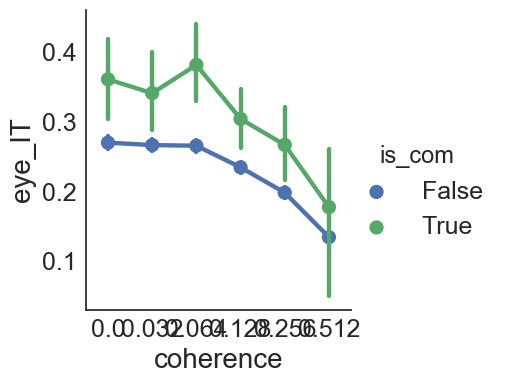

In [189]:
sns.factorplot(x='coherence', y='eye_IT', hue='is_com', data=choices, kind='point')

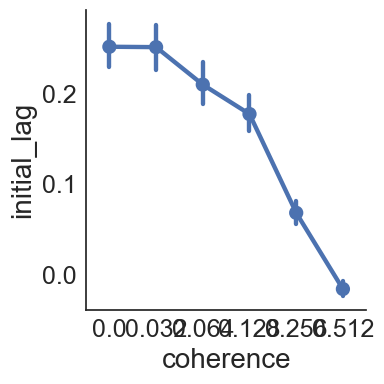

In [132]:
sns.factorplot(x='coherence', y='ID_lag', data=choices, kind='point')
plt.tight_layout()

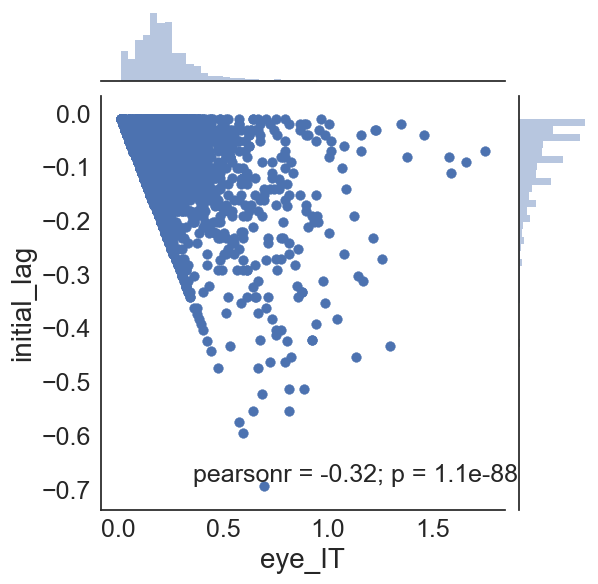

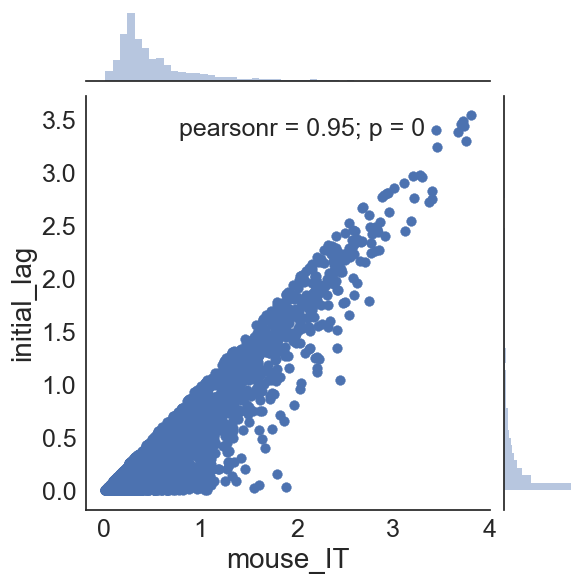

In [129]:
sns.jointplot(data=choices[choices.initial_lag<0], x='eye_IT', y='initial_lag')
sns.jointplot(data=choices[choices.initial_lag>0], x='mouse_IT', y='initial_lag')

In [190]:
sns.jointplot(data=choices_2[choices_2.ID_lag>-np.inf], x='mouse_IT', y='ID_lag')
sns.factorplot(x='coherence', y='ID_lag', data=choices_2[choices_2.ID_lag>-np.inf], kind='point')

AttributeError: 'DataFrame' object has no attribute 'ID_lag'